## CS441: Applied ML - HW 3

### Part 1: Estimating PDFs

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Whole image


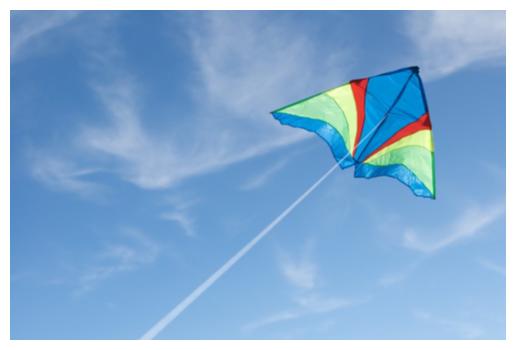

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Foreground


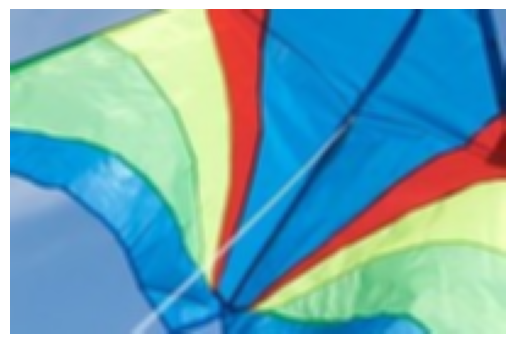

(532, 799)


In [1]:
# initalization code

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
# from google.colab import drive
# from google.colab.patches import cv2_imshow
import cv2

# read images
# drive.mount('/content/drive')
datadir = ""
im = cv2.imread(datadir + 'kite.jpg')  # this is the full image
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)/255
im = cv2.blur(im, (3, 3))

crop = cv2.imread(datadir + 'kite_crop.jpg')  # this is the cropped image
crop = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)/255
crop = cv2.blur(crop, (3, 3))

# displays a single image
def display_image(im):
  plt.imshow(im)
  plt.axis('off')
  plt.show()

# displays the image, score map, thresholded score map, and masked image
def display_score(im, score_map, thresh):
  display_image(im)
  display_image(np.reshape(score, (im.shape[:2])))
  plt.imshow(np.reshape(score_map>thresh, (im.shape[0], im.shape[1])), cmap='gray')
  plt.axis('off')
  plt.show()
  display_image(np.tile(np.reshape(score_map>thresh, (im.shape[0], im.shape[1], 1)), (1,1,3))*im)

print('Whole image')
display_image(im)

print('Foreground')
display_image(crop)
print(im.shape[:2])

#### Method 1 (per channel hist)

In [2]:
# estimate discrete pdf
def estimate_discrete_pdf(values, nvalues, prior=1, nbin = 10):
    '''
      Estimate P(values=v) for each possible v in (0, nvalues)
      Input:
         values: the values of the data
         nvalues: range of values, such that 0 <= values < nvalues
         prior: initial count used to prevent any value from having zero probability
      Output:
         p[nvalues,]: P(values=v) for each v (size should equal number of bins)
    '''
    bins = np.linspace(0, nvalues, nbin)
    digitized_image = np.digitize(values, bins, right=True)
    rc, gc, bc =\
        np.bincount(digitized_image[:,0], minlength=nbin),\
        np.bincount(digitized_image[:,1], minlength=nbin),\
        np.bincount(digitized_image[:,2], minlength=nbin)
    rc[rc == 0] = prior
    gc[gc == 0] = prior
    bc[bc == 0] = prior
    bins_count = np.vstack((rc,gc,bc))
    return digitized_image,bins_count
    
# TO DO

/var/folders/_b/3031t6113hndxtprdbyx8f180000gn/T/ipykernel_87847/1192730414.py:26: RuntimeWarning: invalid value encountered in scalar divide
  score.append(np.log(p_rgb_given_crop / p_rgb_given_im))


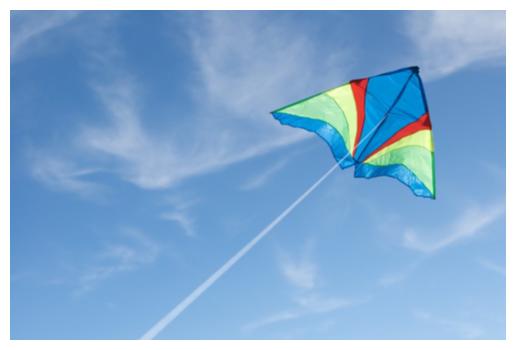

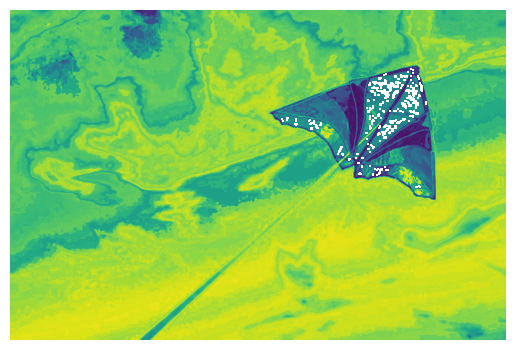

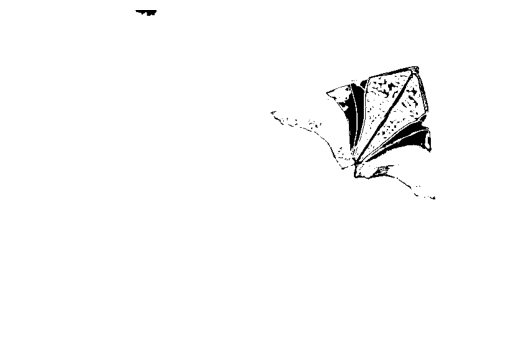

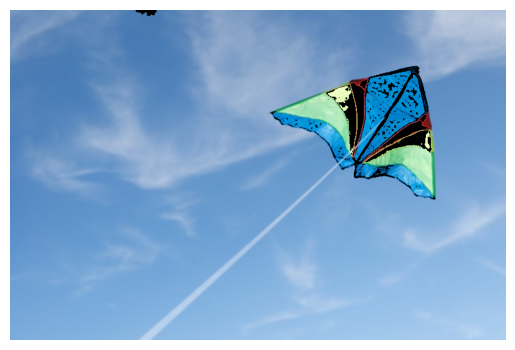

In [43]:
NBIN = 128
# reshape so number of rows is number of pixels and number of columns is 3 (for RGB)
im_3 = np.reshape(im, (im.shape[0]*im.shape[1], 3))
crop_3 = np.reshape(crop, (crop.shape[0]*crop.shape[1], 3))
im_3[np.abs(im_3) < 1e-10] = 0.
crop_3[np.abs(crop_3) < 1e-10] = 0.

# estimate PDFs and compute score per pixel
digitized_im3, count_im3 = estimate_discrete_pdf(im_3, 1.0, 1, NBIN)
digitized_crop3, count_crop3 = estimate_discrete_pdf(crop_3, 1.0, 1, NBIN)

score = []
for pixel in digitized_im3:
    dr, dg, db = pixel
    
    rscore = dr / count_im3[0][dr - 1]
    gscore = dg / count_im3[1][dg - 1]
    bscore = db / count_im3[2][db - 1]
    p_rgb_given_im = rscore * gscore * bscore

    rscore = dr / count_crop3[0][dr - 1]
    gscore = dg / count_crop3[1][dg - 1]
    bscore = db / count_crop3[2][db - 1]
    p_rgb_given_crop = rscore * gscore * bscore

    score.append(np.log(p_rgb_given_crop / p_rgb_given_im))
    
score = np.array(score)
t = 2
display_score(im=im, score_map=score, thresh=t)

#### Method 2 (Kmeans)

In [4]:
# init
# !apt install libomp-dev > /dev/null 2>&1
# !pip install faiss-cpu > /dev/null 2>&1
import faiss

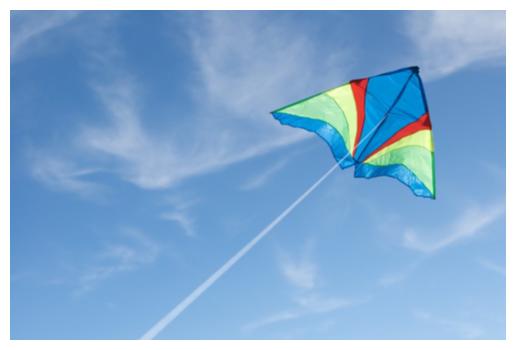

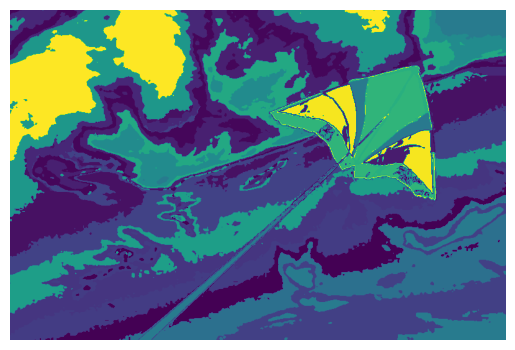

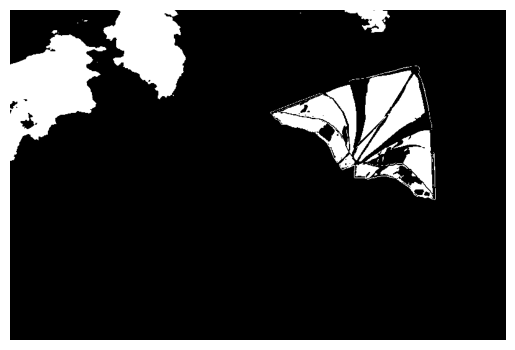

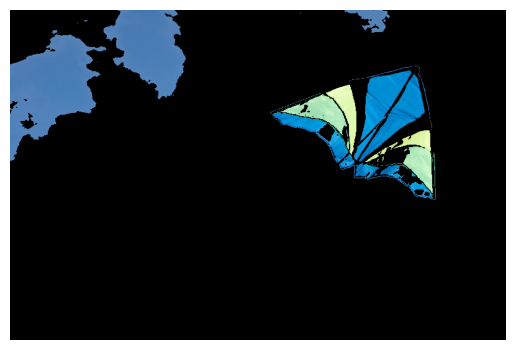

In [5]:
# reshape so number of rows is number of pixels and number of columns is 3 (for RGB)
im_3 = np.reshape(im, (im.shape[0]*im.shape[1], 3))
crop_3 = np.reshape(crop, (crop.shape[0]*crop.shape[1], 3))

# estimate PDFs and compute score per pixel
K = 21

im3_kmeans = faiss.Kmeans(im_3.shape[1], K)
im3_kmeans.train(im_3)
_, im3_indices = im3_kmeans.index.search(im_3, 1)
im3_freq = np.bincount(im3_indices.flatten(), minlength = K)

crop_kmeans = faiss.Kmeans(crop_3.shape[1], K)
crop_kmeans.train(crop_3)
_, crop_indices = crop_kmeans.index.search(crop_3, 1)
crop_freq = np.bincount(crop_indices.flatten(), minlength = K)

score = []
for i in im3_indices:
    score.append(np.log(crop_freq[i - 1] / im3_freq[i - 1]))
score = np.array(score)
t= -1.9
display_score(im=im, score_map=score, thresh=t)

#### Method 3 (GMM)

/var/folders/_b/3031t6113hndxtprdbyx8f180000gn/T/ipykernel_87847/3832495741.py:22: RuntimeWarning: invalid value encountered in log
  score = np.log(gmm_crop.score_samples(im_3) / gmm_im3.score_samples(im_3))


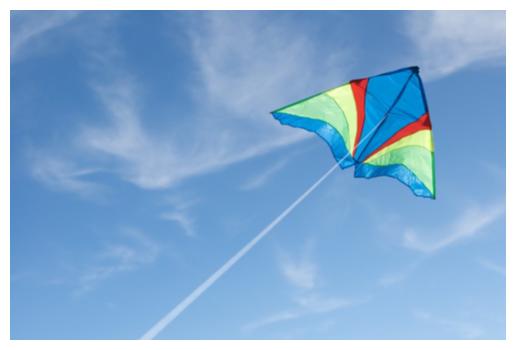

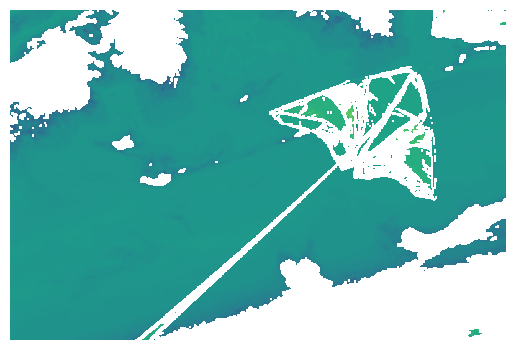

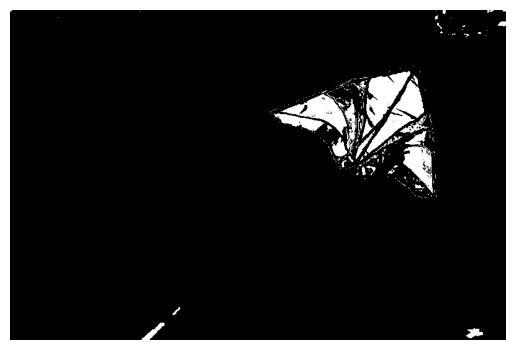

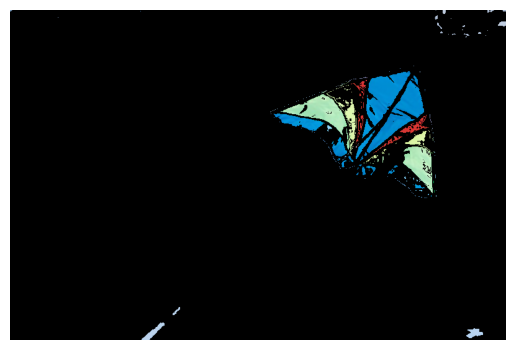

In [48]:
from sklearn.mixture import GaussianMixture

# reshape so number of rows is number of pixels and number of columns is 3 (for RGB)
im_3 = np.reshape(im, (im.shape[0]*im.shape[1], 3))
crop_3 = np.reshape(crop, (crop.shape[0]*crop.shape[1], 3))

ncomp = 10
cov_type = 'diag'
# estimate PDFs and compute score per pixel (can use gmm.score_samples where gmm is the mixture model)
gmm_im3 = GaussianMixture(
    n_components=ncomp,
    covariance_type=cov_type
)
gmm_im3.fit(im_3)

gmm_crop = GaussianMixture(
    n_components=ncomp,
    covariance_type=cov_type
)
gmm_crop.fit(crop_3)

score = np.log(gmm_crop.score_samples(im_3) / gmm_im3.score_samples(im_3))

t = 0.2
display_score(im=im, score_map=score, thresh=t)

## Part 2: Robust Estimation

In [7]:
import numpy as np
from matplotlib import pyplot as plt
# from google.colab import drive

# drive.mount('/content/drive')
datadir = "./"

# load data
T = np.load(datadir + 'salary.npz')
(salary, years, school) = (T['salary'], T['years'], T['school'])

#### 1. No noise
Compute the statistics for the data as a whole

In [8]:
# TO DO
salary_mu = np.mean(salary)
salary_std = np.std(salary)
salary_min = np.min(salary)
salary_max = np.max(salary)
print('Mean: {}  Std: {}  Min: {}   Max: {}'.format(salary_mu, salary_std, salary_min, salary_max))

Mean: 123749.835  Std: 61953.77348723623  Min: 64694.0   Max: 611494.0


#### 2. Percentiles
Assume valid data will fall between the 5th and 95th percentile.

In [9]:
pct = 0.05

interpolation = 'nearest'

pct_5 = np.quantile(salary, pct, interpolation=interpolation)
pct_95 = np.quantile(salary, 1 - pct, interpolation=interpolation)

salary_min = pct_5 - (pct_95 - pct_5) * pct / ( 1 - (2 * pct))
salary_max = pct_95 + (pct_95 - pct_5) * pct / ( 1 - (2 * pct))

corrected = salary[(salary >= salary_min) & (salary <= salary_max)]
salary_mu = np.mean(corrected)
salary_std = np.std(corrected)

print('Mean: {}  Std: {}  Min: {}   Max: {}'.format(salary_mu, salary_std, salary_min, salary_max))

Mean: 113084.95652173914  Std: 16582.440683441288  Min: 75535.77777777778   Max: 159160.22222222222


#### 3. EM
Assume valid data follows a Gaussian distribution, while the fake data has a uniform distribution between the minimum and maximum value of salary.

In [39]:
niter = 20

score_mean = np.mean(salary)
score_std = np.std(salary)
pz = 0.5

for t in range(niter):

    last_mean = score_mean.copy()
    
    # E-step
    p_good = np.zeros_like(salary) + 0.5
    for a in range(len(salary)):
        p_s_good = pz
        p_s_bad = 1 - pz

        p_s_good *= 1/np.sqrt(2*np.pi)/score_std * np.exp(-1/2 * (salary[a] - score_mean)**2 / score_std**2)
        p_s_bad *= 1 / (np.max(salary) - np.min(salary))
        
        p_good[a] = p_s_good / (p_s_good + p_s_bad)

    # print(f"iter: {t}")
    # print(np.round(p_good, 2))

    # M-step

    # estimate mean
    w_score_sum_i = 0
    for a in range(len(salary)):
        w_score_sum_i += salary[a] * p_good[a]
    score_mean = w_score_sum_i / np.sum(p_good)

    # estimate std
    w_sqdiff_sum = 0
    for a in range(len(salary)):
      w_sqdiff_sum += p_good[a]*(salary[a] - score_mean)**2
    score_std = np.sqrt(w_sqdiff_sum / np.sum(p_good))

    # estimate pz
    pz = np.mean(p_good)

    if np.all(np.abs(last_mean-score_mean)<0.00001): # check for convergence
        print(f"EM converged, early stopped, iter {t}")
        break

thresh = 0.5
salary_mu = score_mean
salary_std = score_std
salary_min = np.min(salary[p_good >= thresh])
salary_max = np.max(salary[p_good >= thresh])

print('Mean: {}  Std: {}  Min: {}   Max: {}'.format(salary_mu, salary_std, salary_min, salary_max))

# print the first five indices of salaries that are not likely to be valid
print(np.where(p_good<0.5)[0][:5])

EM converged, early stopped, iter 15
Mean: 111984.3846280201  Std: 17966.362789743955  Min: 64694.0   Max: 169008.0
[ 18  28  49 127 128]


## Part 4: Stretch Goals
Include all your code used for any stretch goals in this section. Add headings where appropriate.

In [ ]:
# TO DO (optional)

In [ ]:
# from https://gist.github.com/jonathanagustin/b67b97ef12c53a8dec27b343dca4abba
# install can take a minute

import os
# @title Convert Notebook to PDF. Save Notebook to given directory
NOTEBOOKS_DIR = "/content/drive/My Drive/CS441/24SP/hw2" # @param {type:"string"}
NOTEBOOK_NAME = "CS441_SP24_HW2_Solution.ipynb" # @param {type:"string"}
#------------------------------------------------------------------------------#
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)
NOTEBOOK_PATH = f"{NOTEBOOKS_DIR}/{NOTEBOOK_NAME}"
assert os.path.exists(NOTEBOOK_PATH), f"NOTEBOOK NOT FOUND: {NOTEBOOK_PATH}"
!apt install -y texlive-xetex texlive-fonts-recommended texlive-plain-generic > /dev/null 2>&1
!jupyter nbconvert "$NOTEBOOK_PATH" --to pdf > /dev/null 2>&1
NOTEBOOK_PDF = NOTEBOOK_PATH.rsplit('.', 1)[0] + '.pdf'
assert os.path.exists(NOTEBOOK_PDF), f"ERROR MAKING PDF: {NOTEBOOK_PDF}"
print(f"PDF CREATED: {NOTEBOOK_PDF}")